## Speech recognition

__You should be able to do this exercise after Lecture 9.__

In this exercise, we will work with the <a href="https://arxiv.org/pdf/1804.03209.pdf">Google Speech Command Dataset</a>, which can be downloaded from <a href="http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz">here</a> (note: you do not need to download the full dataset, but it will allow you to play around with the raw audiofiles). This dataset contains 105,829 one-second long audio files with utterances of 35 common words.

We will use a subset of this dataset as indicated in the table below.

| Word | How many? | Class # |
| :-: | :-: | :-: |
| Yes | 4,044 | 3 |
| No | 3,941 | 1 |
| Stop | 3,872 | 2 |
| Go | 3,880 | 0 |

The data is given in the files `XSound.npy` and `YSound.npy`, both of which can be imported using `numpy.load`. `XSound.npy` contains spectrograms (_e.g._, matrices with a time-axis and a frequency-axis of size 62 (time) x 65 (frequency)). `YSound.npy` contains the class number, as indicated in the table above.

__(a)__ Train a convolutional neural network on the data. Find a good set of hyperparameters for the model. Do you think a convolutional neural network is suitable for this kind of problem? Why/why not?

__(b)__ Classify instances of the test set using your models. Draw a confusion matrix and comment on the results.

__(c)__ Choose one other algorithm from the course, and redo (a) and (b) using this algorithm. Supply a brief discussion of why we would expect this algorithm to do better/worse than the CNN.

In [42]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import callbacks
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

words = {0:'Go',1:'No',2:'Stop',3:'Yes'}

# Load XSound.npy
XSound = np.load('XSound.npy')

# Load YSound.npy
YSound = np.load('YSound.npy')

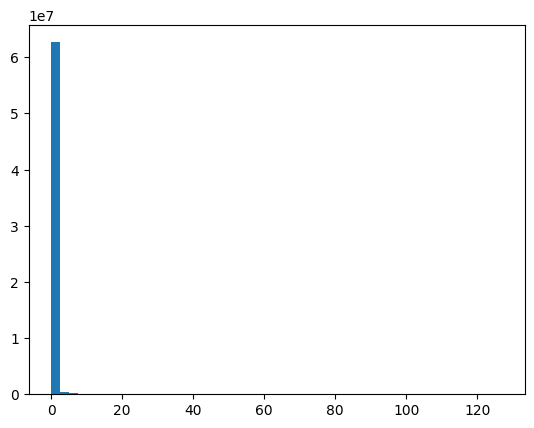

In [30]:
# show histogram of XSound

plt.hist(XSound.flatten(), bins=50)
plt.show()

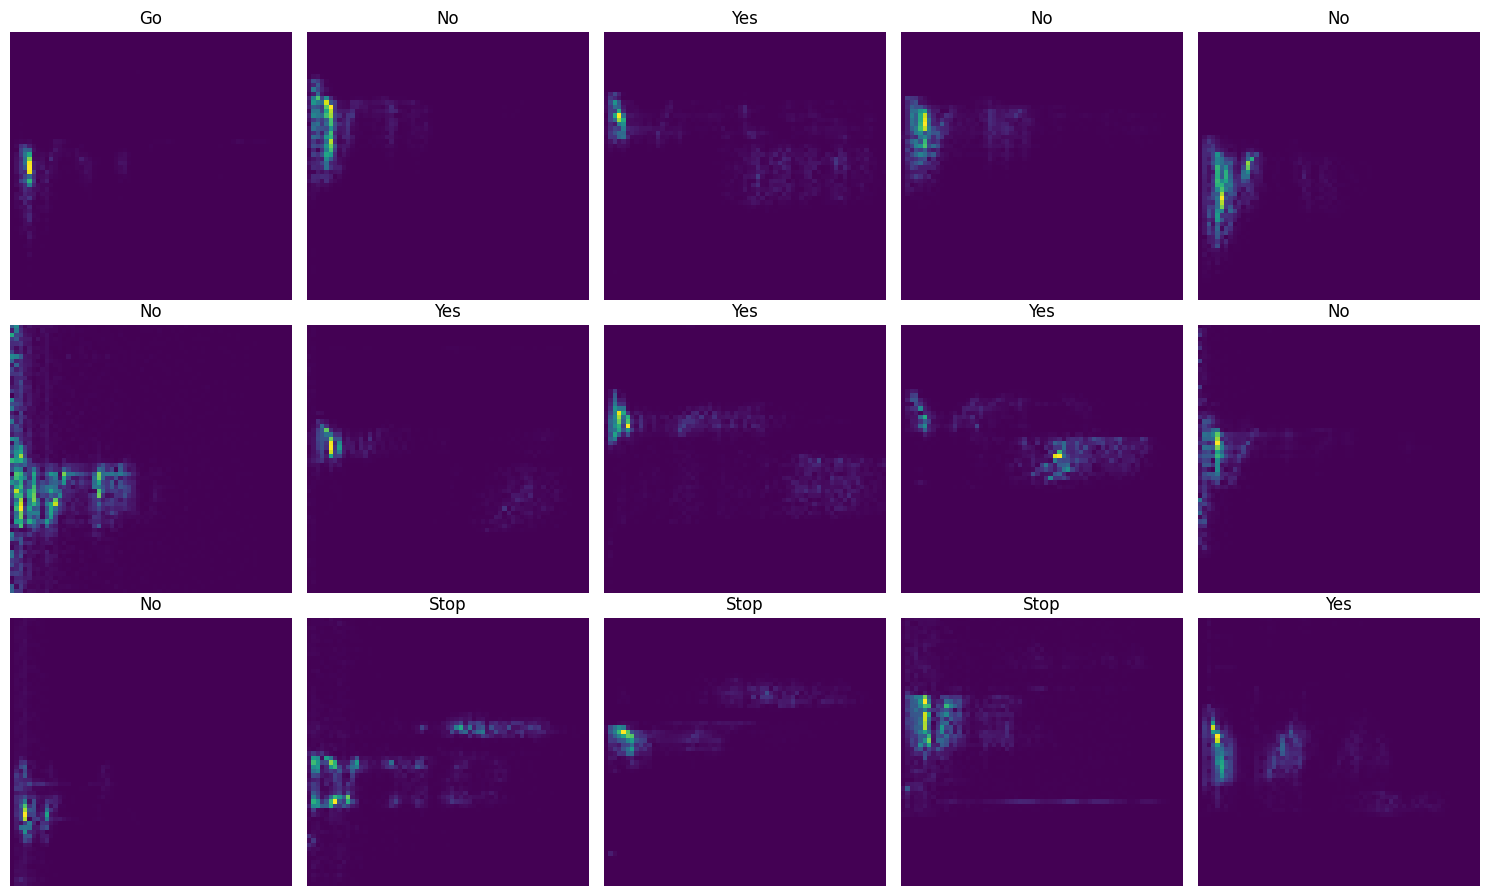

In [44]:
# plot a spectrogram of 15 random samples and their labels

plt.figure(figsize=(15, 9))  # Set the figure size

for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(XSound[i])
    plt.title(words[YSound[i]])
    plt.axis('off')

plt.tight_layout()  # Adjust the padding between and around the subplots
plt.show()

In [15]:
# do train test validation split
# Split the data into training, testing, and validation sets
X_trainval, X_test, y_trainval, y_test = train_test_split(XSound, YSound, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)

In [16]:
# Define the model
model = Sequential()

# Add layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(62, 65, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # 4 classes

# Set the learning rate
learning_rate = 0.001

# Compile the model with a specified learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

# Reshape the data to include the channel dimension
X_train = X_train.reshape(-1, 62, 65, 1)
X_val = X_val.reshape(-1, 62, 65, 1)
X_test = X_test.reshape(-1, 62, 65, 1)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 60, 63, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 31, 32)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 30, 31, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 29, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 64)       

In [18]:
# Define early stopping callback
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=3,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  
)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, callbacks=[early_stopping])

Epoch 1/20


2023-11-16 15:51:18.049366: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 162344520 exceeds 10% of free system memory.


315/315 [==============================] - 24s 75ms/step - loss: 0.8324 - accuracy: 0.6572 - val_loss: 0.5780 - val_accuracy: 0.7859
Epoch 2/20
315/315 [==============================] - 22s 69ms/step - loss: 0.5631 - accuracy: 0.7718 - val_loss: 0.4498 - val_accuracy: 0.8392
Epoch 3/20
315/315 [==============================] - 22s 69ms/step - loss: 0.4627 - accuracy: 0.8183 - val_loss: 0.3611 - val_accuracy: 0.8662
Epoch 4/20
315/315 [==============================] - 24s 77ms/step - loss: 0.4184 - accuracy: 0.8383 - val_loss: 0.3607 - val_accuracy: 0.8765
Epoch 5/20
315/315 [==============================] - 26s 81ms/step - loss: 0.3778 - accuracy: 0.8546 - val_loss: 0.3267 - val_accuracy: 0.8733
Epoch 6/20
315/315 [==============================] - 23s 72ms/step - loss: 0.3627 - accuracy: 0.8628 - val_loss: 0.3014 - val_accuracy: 0.8904
Epoch 7/20
315/315 [==============================] - 22s 71ms/step - loss: 0.3307 - accuracy: 0.8720 - val_loss: 0.3110 - val_accuracy: 0.8912
Epo

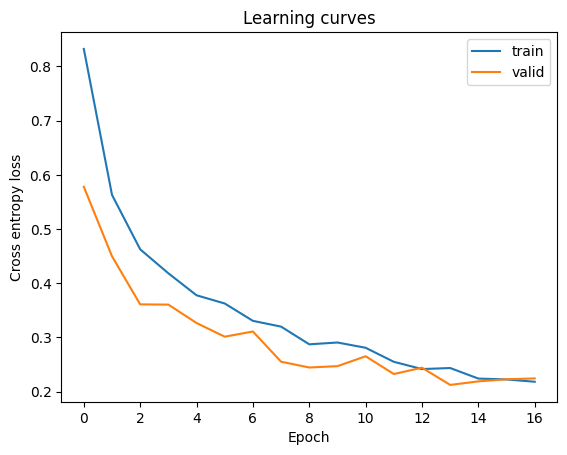

In [22]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Learning curves")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'valid')
plt.legend()
plt.show()

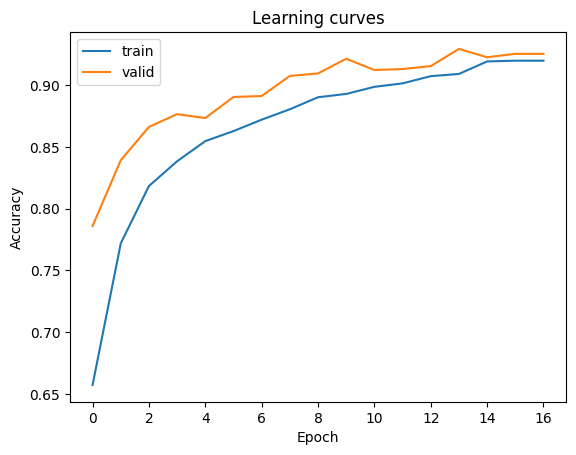

In [23]:
plt.figure()
plt.title("Learning curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'valid')
plt.legend()
plt.show()

In [25]:
# Fit model to train and validation data

# Define the model
model = Sequential()

# Add layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(62, 65, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # 4 classes

# Set the learning rate
learning_rate = 0.001

# Compile the model with a specified learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])


history = model.fit(X_trainval, y_trainval, validation_data=(X_test, y_test), epochs=20, batch_size=32, callbacks=[early_stopping])

Epoch 1/20


2023-11-16 16:01:28.129766: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 202934680 exceeds 10% of free system memory.


394/394 [==============================] - 28s 69ms/step - loss: 0.7877 - accuracy: 0.6742 - val_loss: 0.5714 - val_accuracy: 0.8113
Epoch 2/20
394/394 [==============================] - 21s 53ms/step - loss: 0.5334 - accuracy: 0.7852 - val_loss: 0.4709 - val_accuracy: 0.8421
Epoch 3/20
394/394 [==============================] - 20s 51ms/step - loss: 0.4483 - accuracy: 0.8237 - val_loss: 0.3753 - val_accuracy: 0.8764
Epoch 4/20
394/394 [==============================] - 27s 69ms/step - loss: 0.4061 - accuracy: 0.8399 - val_loss: 0.3349 - val_accuracy: 0.8895
Epoch 5/20
394/394 [==============================] - 29s 74ms/step - loss: 0.3641 - accuracy: 0.8650 - val_loss: 0.3040 - val_accuracy: 0.8961
Epoch 6/20
394/394 [==============================] - 28s 71ms/step - loss: 0.3324 - accuracy: 0.8747 - val_loss: 0.2917 - val_accuracy: 0.9028
Epoch 7/20
394/394 [==============================] - 28s 70ms/step - loss: 0.3073 - accuracy: 0.8836 - val_loss: 0.2778 - val_accuracy: 0.9095
Epo

In [26]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

99/99 - 1s - loss: 0.2059 - accuracy: 0.9304 - 1s/epoch - 12ms/step


A CNN is good for this task since the words are represented as a spectrogram so it works the same way as an image. A CNN is good at extracting key features from this kind of data.

99/99 [==============================] - 1s 13ms/step


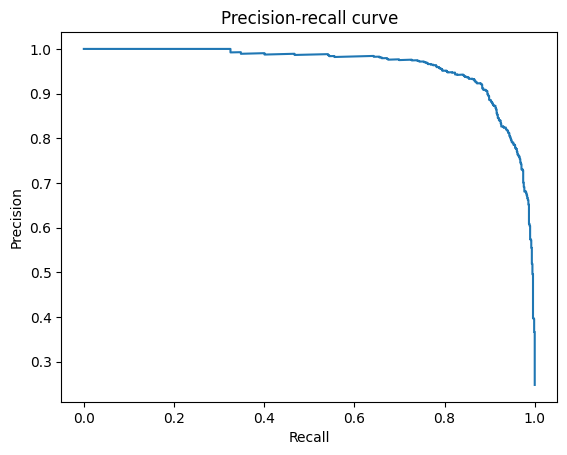

In [35]:
# recall-precision curve

from sklearn.metrics import precision_recall_curve

y_scores = model.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_scores[:, 1], pos_label=1)

plt.figure()
plt.title("Precision-recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot(recall, precision)
plt.show()

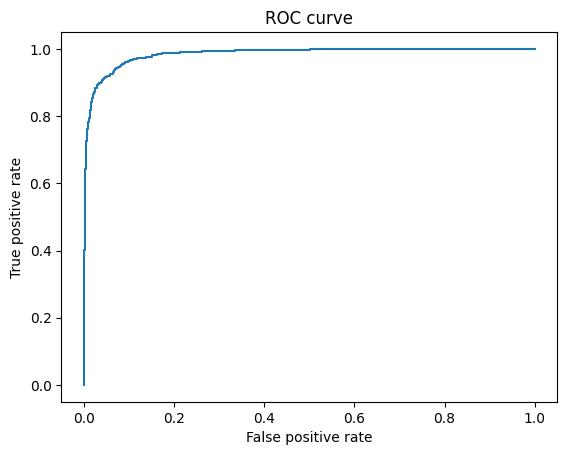

In [36]:
# ROC curve

from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_scores[:, 1], pos_label=1)

plt.figure()
plt.title("ROC curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot(fpr, tpr)
plt.show()

# b)

In [50]:
# Try to classify 10 random samples from the test set

# Get 10 random samples from the test set
idxs = np.random.randint(0, len(X_test), 30)

# Get the predictions
preds = model.predict(X_test[idxs])

# Print the predicted outputs as the word
for i in range(len(idxs)):
    print(f'Predicted: {words[np.argmax(preds[i])]} Actual: {words[y_test[idxs[i]]]}')

1/1 [==============================] - 0s 34ms/step
Predicted: Go Actual: No
Predicted: No Actual: No
Predicted: Stop Actual: Stop
Predicted: No Actual: No
Predicted: No Actual: No
Predicted: Stop Actual: Stop
Predicted: Stop Actual: Stop
Predicted: Go Actual: Go
Predicted: Yes Actual: Yes
Predicted: No Actual: Go
Predicted: Go Actual: Go
Predicted: Stop Actual: Stop
Predicted: Yes Actual: Yes
Predicted: Stop Actual: Stop
Predicted: No Actual: No
Predicted: No Actual: No
Predicted: Go Actual: Go
Predicted: Yes Actual: Stop
Predicted: Yes Actual: Yes
Predicted: Stop Actual: Stop
Predicted: Yes Actual: Yes
Predicted: Stop Actual: Stop
Predicted: Go Actual: Go
Predicted: Yes Actual: Yes
Predicted: Yes Actual: Yes
Predicted: Go Actual: Go
Predicted: Yes Actual: Yes
Predicted: Go Actual: Go
Predicted: Go Actual: Go
Predicted: Go Actual: Go


Few problems with telling appart no and go.

99/99 [==============================] - 1s 13ms/step


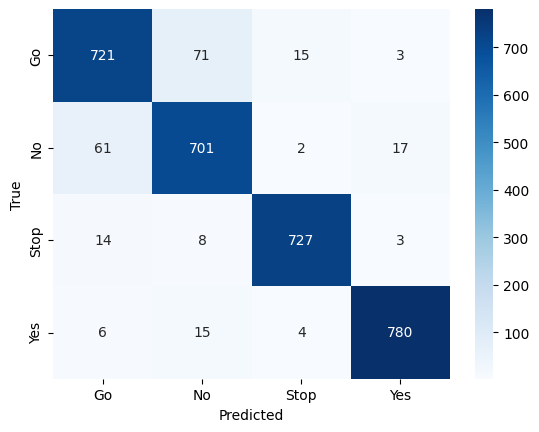

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns



y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)

# Convert the labels to words
word_labels = [words[i] for i in range(4)]

# Create a heatmap
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=word_labels, yticklabels=word_labels)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


The confusion matrix shows that the model has a slight problem telling Go and No apart. Since there are some similarities in those sounds.

# C)

We want to try a simple one layer NN. This will perform worse than the CNN since it is not as good at extracting features from the data.

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

# Define the model
model = Sequential()

# Add layers
model.add(Flatten(input_shape=(62, 65, 1)))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # 4 classes

# learning rate
learning_rate = 0.001

# Compile the model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

# Reshape the data to include the channel dimension
X_train = X_train.reshape(-1, 62, 65, 1)
X_val = X_val.reshape(-1, 62, 65, 1)
X_test = X_test.reshape(-1, 62, 65, 1)

In [56]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=20,           
    restore_best_weights=True  
)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
315/315 [==============================] - 1s 3ms/step - loss: 0.9989 - accuracy: 0.6370 - val_loss: 0.7672 - val_accuracy: 0.7355
Epoch 2/100
315/315 [==============================] - 1s 3ms/step - loss: 0.7902 - accuracy: 0.7085 - val_loss: 0.7621 - val_accuracy: 0.7371
Epoch 3/100
315/315 [==============================] - 1s 3ms/step - loss: 0.7394 - accuracy: 0.7364 - val_loss: 0.7369 - val_accuracy: 0.7577
Epoch 4/100
315/315 [==============================] - 1s 3ms/step - loss: 0.7288 - accuracy: 0.7351 - val_loss: 0.7561 - val_accuracy: 0.7486
Epoch 5/100
315/315 [==============================] - 1s 3ms/step - loss: 0.7144 - accuracy: 0.7380 - val_loss: 0.7242 - val_accuracy: 0.7617
Epoch 6/100
315/315 [==============================] - 1s 3ms/step - loss: 0.6956 - accuracy: 0.7479 - val_loss: 0.7623 - val_accuracy: 0.7379
Epoch 7/100
315/315 [==============================] - 1s 3ms/step - loss: 0.6833 - accuracy: 0.7510 - val_loss: 0.7660 - val_accuracy: 0.7375

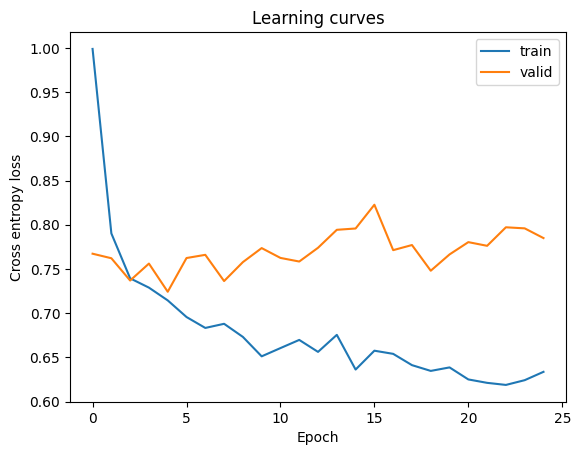

In [57]:
# plot learning curves

import matplotlib.pyplot as plt

plt.figure()
plt.title("Learning curves")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'valid')
plt.legend()
plt.show()

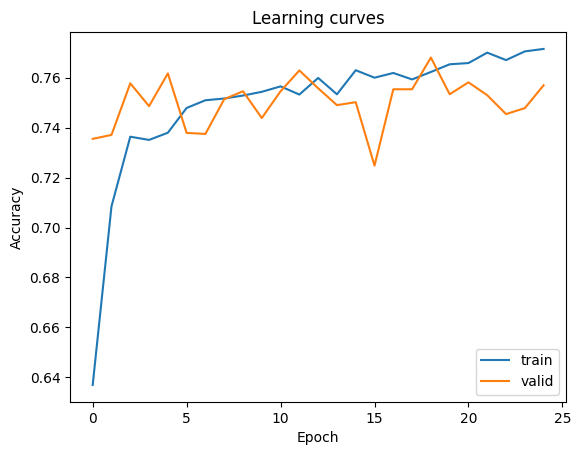

In [58]:
# plot accuracy

plt.figure()
plt.title("Learning curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'valid')
plt.legend()
plt.show()


In [59]:
# evaluate the model

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

99/99 - 0s - loss: 0.7393 - accuracy: 0.7643 - 132ms/epoch - 1ms/step


99/99 [==============================] - 0s 1ms/step


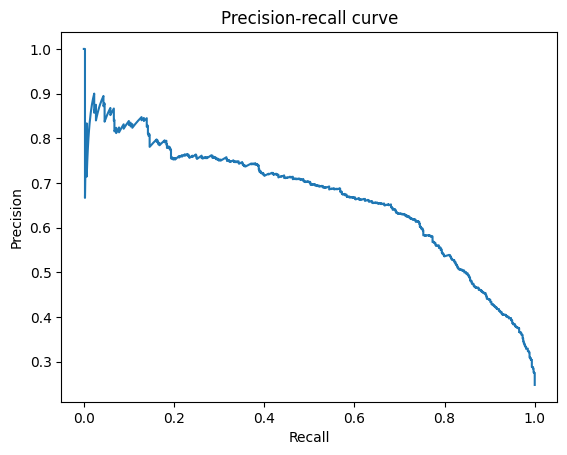

In [61]:
# recall-precision curve

from sklearn.metrics import precision_recall_curve

y_scores = model.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_scores[:, 1], pos_label=1)

plt.figure()
plt.title("Precision-recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot(recall, precision)
plt.show()


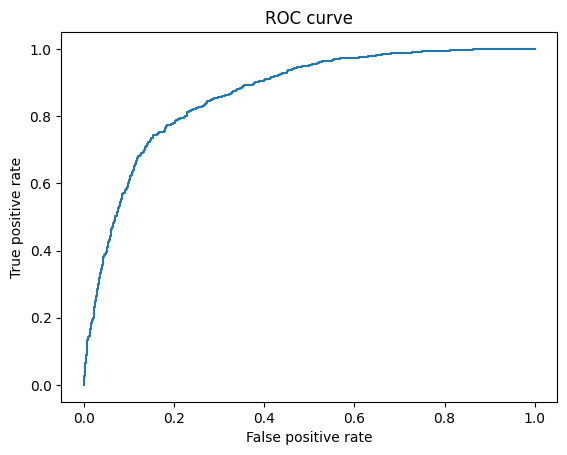

In [62]:
# plot ROC curve

from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_scores[:, 1], pos_label=1)

plt.figure()
plt.title("ROC curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot(fpr, tpr)
plt.show()


In [63]:
# try to classify 10 random samples from the test set

# Get 10 random samples from the test set
idxs = np.random.randint(0, len(X_test), 20)

# Get the predictions
preds = model.predict(X_test[idxs])

# Print the predicted outputs as the word
for i in range(len(idxs)):
    print(f'Predicted: {words[np.argmax(preds[i])]} Actual: {words[y_test[idxs[i]]]}')

1/1 [==============================] - 0s 22ms/step
Predicted: Yes Actual: Yes
Predicted: No Actual: No
Predicted: Stop Actual: Go
Predicted: No Actual: No
Predicted: Yes Actual: Yes
Predicted: Stop Actual: Stop
Predicted: Go Actual: Go
Predicted: Stop Actual: Stop
Predicted: No Actual: Yes
Predicted: Go Actual: No
Predicted: Go Actual: Go
Predicted: Stop Actual: Stop
Predicted: No Actual: No
Predicted: No Actual: No
Predicted: Yes Actual: Stop
Predicted: No Actual: No
Predicted: Stop Actual: Stop
Predicted: Yes Actual: No
Predicted: Yes Actual: Yes
Predicted: Stop Actual: Stop


99/99 [==============================] - 0s 1ms/step


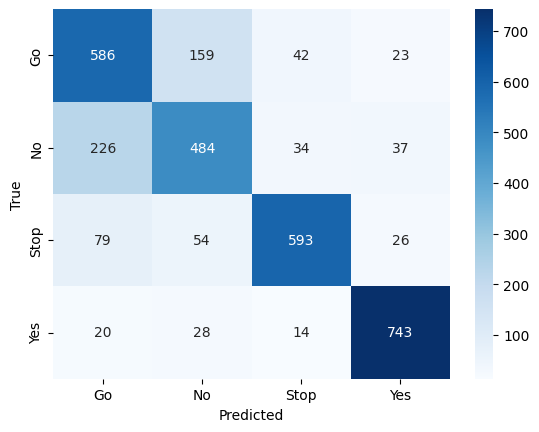

In [64]:
# confusion matrix

from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)

# Convert the labels to words
word_labels = [words[i] for i in range(4)]

# Create a heatmap
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=word_labels, yticklabels=word_labels)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
